# Mall Customers

<h4> Acquire data from mall_customers.customers in mysql database </h4>

-----

In [1]:
import pandas as pd
import numpy as np
import os

# acquire
from env import host, user, password
from pydataset import data
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

os.path.isfile('mallcustomers_df.csv')


# Create helper function to get the necessary connection url.
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

    
    

# Use the above helper function and a sql query in a single function.
def new_mall_data():
    '''
    This function reads data from the Codeup db into a df.
    '''
    mall_customers_sql = "SELECT * \
                  FROM customers;;" \
    
    
    return pd.read_sql(mall_customers_sql, get_connection('mall_customers'))

In [2]:
df = new_mall_data()

-----

<h4>Summarize data (include distributions and descriptive statistics)</h4>

----

In [3]:
df.shape

(200, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


<AxesSubplot:>

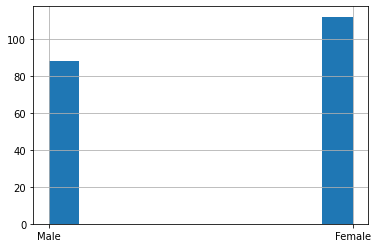

In [6]:
df.gender.hist()

<AxesSubplot:>

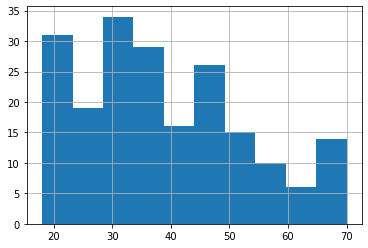

In [7]:
df.age.hist()

<AxesSubplot:>

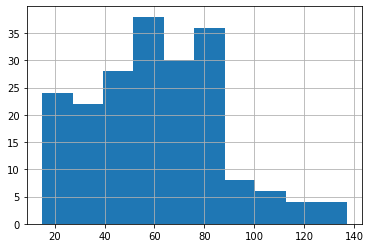

In [8]:
df.annual_income.hist()

<AxesSubplot:>

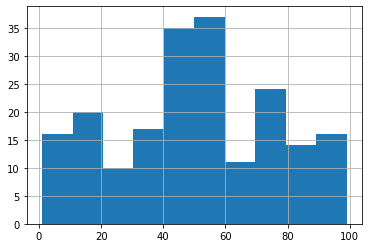

In [9]:
df.spending_score.hist()

In [10]:
def missing_zero_values_table(df):
    
    '''This function will look at any data set and report back on zeros and nulls for every column while also giving percentages of total values
        and also the data types. The message prints out the shape of the data frame and also tells you how many columns have nulls '''
    
    
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    null_count = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, null_count, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'null_count', 2 : '% of Total Values'})
    mz_table['Total Zeroes + Null Values'] = mz_table['Zero Values'] + mz_table['null_count']
    mz_table['% Total Zero + Null Values'] = 100 * mz_table['Total Zeroes + Null Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] >= 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " +  str((mz_table['null_count'] != 0).sum()) +
          " columns that have NULL values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)

    return mz_table

missing_zero_values_table(df)

Your selected dataframe has 5 columns and 200 Rows.
There are 0 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
customer_id,0,0,0.0,0,0.0,int64
gender,0,0,0.0,0,0.0,object
age,0,0,0.0,0,0.0,int64
annual_income,0,0,0.0,0,0.0,int64
spending_score,0,0,0.0,0,0.0,int64


<h4> Detect outliers using IQR </h4>

In [11]:
q1, q3 = df.annual_income.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr

print(f'The upper bound quartile is {upperbound} while our lower bound quartile is {lowerbound}. These outliers will be addressed in prep')

The upper bound quartile is 187.5 while our lower bound quartile is -68.0. These outliers will be addressed in prep


In [12]:
q1, q3 = df.spending_score.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr

print(f'The upper bound quartile is {upperbound} while our lower bound quartile is {lowerbound}. These outliers will be addressed in prep')

The upper bound quartile is 187.75 while our lower bound quartile is -80.0. These outliers will be addressed in prep


<AxesSubplot:xlabel='spending_score'>

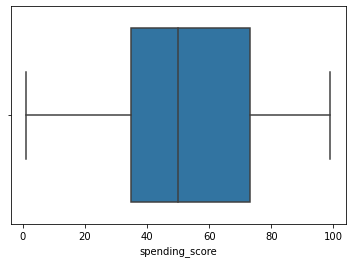

In [13]:
sns.boxplot(data = df, x = 'spending_score')

<AxesSubplot:xlabel='annual_income'>

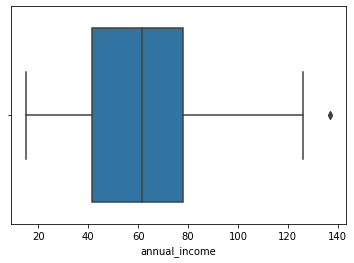

In [14]:
sns.boxplot(data = df, x = 'annual_income')

<AxesSubplot:xlabel='age'>

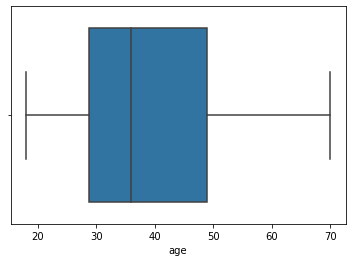

In [15]:
sns.boxplot(data = df, x = 'age')

<h4>Takeaways</h4>

Outliers don't seem to be a large issue here. Annual income has a couple but it doesn't appear to be skewing the data too much according to the histogram.

In [16]:
def features_missing(df):
    
    '''This function creates a new dataframe that analyzes the total features(columns) missing for the rows in
    the data frame. It also give s a percentage'''
    
    
    df2 = df.isnull().sum(axis =1).value_counts().sort_index(ascending=False)
    df2 = pd.DataFrame(df2)
    df2.reset_index(level=0, inplace=True)
    df2.columns= ['total_features_missing', 'total_rows_affected'] 
    df2['pct_features_missing']= round((df2.total_features_missing /df.shape[1]) * 100, 2)
    df2 = df2[['total_features_missing', 'pct_features_missing', 'total_rows_affected']]
    
    return df2

In [17]:
features_missing(df)

,total_features_missing,pct_features_missing,total_rows_affected
0,0,0.0,200


In [18]:
dummycols = ['gender']

In [19]:
df = pd.get_dummies(df, columns= dummycols)

In [20]:
df.head()

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
0,1,19,15,39,0,1
1,2,21,15,81,0,1
2,3,20,16,6,1,0
3,4,23,16,77,1,0
4,5,31,17,40,1,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     200 non-null    int64
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
 4   gender_Female   200 non-null    uint8
 5   gender_Male     200 non-null    uint8
dtypes: int64(4), uint8(2)
memory usage: 6.8 KB


In [22]:
def split_data(df):
    '''
    split our data,
    takes in a pandas dataframe
    returns: three pandas dataframes, train, test, and validate
    '''
    train_val, test = train_test_split(df, train_size=0.8, random_state=123)
    train, validate = train_test_split(train_val, train_size=0.7, random_state=123)
    
    
    return train, validate, test

In [23]:
train, validate, test = split_data(df)

In [24]:
train.shape, validate.shape, test.shape

((112, 6), (48, 6), (40, 6))

In [25]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

In [29]:
object_cols = get_object_cols(df)

In [30]:
def get_numeric_X_cols(train, object_cols):
    '''
    takes in a dataframe and list of object column names
    and returns a list of all other columns names, the non-objects. 
    '''
    numeric_cols = [col for col in train.columns.values if col not in object_cols]
    
    return numeric_cols

In [32]:
numeric_cols = get_numeric_X_cols(train, object_cols)

In [33]:
def min_max_scale(train, validate, test, numeric_cols):
    '''
    this function takes in 3 dataframes with the same columns, 
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).
     
    scaler = MinMaxScaler(copy=True).fit(train)

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    train_scaled_array = scaler.transform(train[numeric_cols])
    validate_scaled_array = scaler.transform(validate[numeric_cols])
    test_scaled_array = scaler.transform(test[numeric_cols])

    # convert arrays to dataframes
    train_scaled = pd.DataFrame(train_scaled_array, 
                                columns=numeric_cols).\
                                set_index([train.index.values])

    validate_scaled = pd.DataFrame(validate_scaled_array,
                                   columns=numeric_cols).\
                                   set_index([validate.index.values])

    test_scaled = pd.DataFrame(test_scaled_array,
                               columns=numeric_cols).\
                                set_index([test.index.values])

    
    return train_scaled, validate_scaled, test_scaled

In [34]:
train_scaled, validate_scaled, test_scaled = min_max_scale(train, validate, test, numeric_cols)

In [35]:
train_scaled

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
123,0.618090,0.403846,0.442623,0.957447,0.0,1.0
76,0.381910,0.519231,0.319672,0.553191,1.0,0.0
171,0.859296,0.192308,0.590164,0.787234,0.0,1.0
10,0.050251,0.942308,0.032787,0.138298,0.0,1.0
35,0.175879,0.057692,0.147541,0.851064,1.0,0.0
39,0.195980,0.038462,0.180328,0.787234,1.0,0.0
98,0.492462,0.576923,0.377049,0.436170,0.0,1.0
57,0.286432,0.980769,0.237705,0.478723,0.0,1.0
103,0.517588,0.153846,0.385246,0.574468,0.0,1.0
44,0.221106,0.596154,0.196721,0.287234,1.0,0.0
